In [166]:
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from dataclasses import dataclass
import concurrent.futures
from collections import defaultdict
import typing
from torch import optim
import torch
import os
import random
import copy


%load_ext autoreload
%autoreload 2
import env
import network
import player


BOARD_XSIZE = env.BOARD_XSIZE
BOARD_YSIZE = env.BOARD_YSIZE

DIMS=(BOARD_XSIZE,BOARD_YSIZE)


EPISODES_PER_AGENT = 32
TRAIN_EPOCHS = 500000
MODEL_SAVE_INTERVAL = 100
MAKE_OPPONENT_INTERVAL = 2000
SUMMARY_STATS_INTERVAL = 10
RANDOM_SEED = 42

SUMMARY_DIR = './summary'
MODEL_DIR = './models'

# create result directory
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)

use_cuda = torch.cuda.is_available()
torch.manual_seed(RANDOM_SEED)

cuda = torch.device("cuda")
cpu = torch.device("cpu")

if use_cuda:
    device = cuda
else:
    device = cpu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# TODO: restore neural net parameters

impostor_actor = network.Actor().to(device)
impostor_critic = network.Critic().to(device)
impostor_actor_optimizer = optim.Adam(impostor_actor.parameters(), lr=network.ACTOR_LR)
impostor_critic_optimizer = optim.Adam(impostor_critic.parameters(), lr=network.CRITIC_LR)

crewmate_actor = network.Actor().to(device)
crewmate_critic = network.Critic().to(device)
crewmate_actor_optimizer = optim.Adam(crewmate_actor.parameters(), lr=network.ACTOR_LR)
crewmate_critic_optimizer = optim.Adam(crewmate_critic.parameters(), lr=network.CRITIC_LR)

# Get Writer
writer = SummaryWriter(log_dir=SUMMARY_DIR)

impostor_step = 0
crewmate_step = 0

In [168]:

def random_valid_location() -> tuple[int, int]:
    x = np.random.randint(0, BOARD_XSIZE)
    y = np.random.randint(0, BOARD_YSIZE)
    return (x, y)


@dataclass
class GameSummary:
    actor_index: int 
    engines: list[player.Player]
    is_impostor: list[bool]

    def configuration(self) -> tuple[str, str, str]:
        names = sorted(e.name() for i,e in enumerate(self.engines) if i != self.actor_index)
        return tuple(names)

def play(actor_engine: player.ActorPlayer, actor_is_impostor: bool, other_engines: list[player.Player]) -> tuple[
    list[env.Observation],
    list[env.Action],
    list[np.ndarray],
    list[env.Reward],
    list[env.Advantage],
    list[env.Reward],
    GameSummary
]:
    # create environment
    initial_state = env.State(
        [],
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
    )

    # randomize task location
    for _ in range(5):
        location = random_valid_location()
        initial_state.tasks[location] += 5

    # create actor player at random location
    actor_playerstate = env.PlayerState(random_valid_location(), actor_is_impostor, False)
    # create other players at random locations
    other_playerstate = [env.PlayerState(random_valid_location(), False, False) for _ in other_engines]
    # If the actor is not an impostor, then the impostor is randomly chosen from the others.
    if not actor_is_impostor:
        random.choice(other_playerstate).impostor = True

    # set the players in the environment
    initial_state.players = [actor_playerstate] + other_playerstate
    # set the player engines
    player_engines = [actor_engine] + other_engines

    # shuffle the player indices such that the corresponding player states and engines have the same indices
    random_indices = np.random.permutation(len(player_engines))
    initial_state.players = [initial_state.players[i] for i in random_indices]
    player_engines = [player_engines[i] for i in random_indices]

    actor_index = env.Player(np.argwhere(random_indices==0)[0][0])

    e = env.Env(initial_state)

    s_t: list[env.Observation] = []
    a_t: list[env.Action] = []
    p_t: list[np.ndarray] = []
    r_t: list[env.Reward] = []
    # play the game
    while not e.game_over():
        for player, player_engine in enumerate(player_engines):
            player = env.Player(player)
            # if the player is the actor we're gathering data for, then we need to store the data
            if player == actor_index:
                obs, action_probs, chosen_action = player_engine.play(player, e)
                s_t += [obs]
                p_t += [action_probs]
                a_t += [chosen_action]
                e.play(chosen_action, player)
            else:
                # skip dead players
                if e.game_over_for(player):
                    continue
                # get chosen action from player engine and play it
                _, _, chosen_action = player_engine.play(player, e)
                e.play(chosen_action, player)
        # step and get rewards
        rewards = e.step()
        r_t += [rewards[actor_index]]
        # if the actor we're gathering data for is dead, then we need to stop
        if e.game_over_for(env.Player(actor_index)):
            break

    # compute advantage and value
    critic_network = impostor_critic if actor_is_impostor else crewmate_critic
    d_t = network.compute_advantage(critic_network, s_t, r_t)
    v_t = network.compute_value(r_t)

    summary = GameSummary(int(actor_index), player_engines, [e.state.players[i].impostor for i in range(len(e.state.players))])

    return s_t, a_t, p_t, r_t, d_t, v_t, summary


In [169]:
opponent_pool: list[player.Player] = [
    player.RandomPlayer(),
    player.GreedyPlayer(),
]

# a temp buffer of the current model's rewards
crewmate_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])
impostor_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])


# the history of rewards over time
crewmate_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])
impostor_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])

In [170]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    for _ in range(TRAIN_EPOCHS):
        crewmate_s_batch:list[env.Observation] = []
        crewmate_a_batch:list[env.Action] = []
        crewmate_p_batch:list[np.ndarray] = []
        crewmate_r_batch:list[env.Reward] = []
        crewmate_d_batch:list[env.Advantage] = []
        crewmate_v_batch:list[env.Value] = []
        
        impostor_s_batch:list[env.Observation] = []
        impostor_a_batch:list[env.Action] = []
        impostor_p_batch:list[np.ndarray] = []
        impostor_r_batch:list[env.Reward] = []
        impostor_d_batch:list[env.Advantage] = []
        impostor_v_batch:list[env.Value] = []

        # create actor player
        nn_player = player.ActorPlayer(
            impostor_actor, impostor_critic, impostor_step,
            crewmate_actor, crewmate_critic, crewmate_step,
        )

        futures = []
        for i in range(EPISODES_PER_AGENT):
            others = [random.choice(opponent_pool)]*3
            # play the game
            future = executor.submit(play, nn_player, False, others)
            futures.append(future)

        for i in range(EPISODES_PER_AGENT):
            others = [random.choice(opponent_pool)]*3
            # play the game
            future = executor.submit(play, nn_player, True, others)
            futures.append(future)

        
        for future in concurrent.futures.as_completed(futures):
            s_t, a_t, p_t, r_t, d_t, v_t, game_summary = future.result()

            configuration = game_summary.configuration()
            r = np.sum(r_t)

            if game_summary.is_impostor[game_summary.actor_index]:
                impostor_s_batch += s_t
                impostor_a_batch += a_t
                impostor_p_batch += p_t
                impostor_r_batch += r_t
                impostor_d_batch += d_t
                impostor_v_batch += v_t
                # statistics
                impostor_rewards_vs[configuration] += [r]
            else:
                crewmate_s_batch += s_t
                crewmate_a_batch += a_t
                crewmate_p_batch += p_t
                crewmate_r_batch += r_t
                crewmate_d_batch += d_t
                crewmate_v_batch += v_t
                # statistics
                crewmate_rewards_vs[configuration] += [r]


        crewmate_actor_losses, crewmate_critic_losses = network.train_ppo(
            crewmate_actor,
            crewmate_critic,
            crewmate_actor_optimizer,
            crewmate_critic_optimizer,
            crewmate_s_batch,
            crewmate_a_batch,
            crewmate_p_batch,
            crewmate_d_batch,
            crewmate_v_batch
        )

        impostor_actor_losses, impostor_critic_losses = network.train_ppo(
            impostor_actor,
            impostor_critic,
            impostor_actor_optimizer,
            impostor_critic_optimizer,
            impostor_s_batch,
            impostor_a_batch,
            impostor_p_batch,
            impostor_d_batch,
            impostor_v_batch
        )

        for crewmate_actor_loss, crewmate_critic_loss, impostor_actor_loss, impostor_critic_loss in zip(crewmate_actor_losses, crewmate_critic_losses, impostor_actor_losses, impostor_critic_losses):
            writer.add_scalar('impostor_actor_loss', impostor_actor_loss, impostor_step)
            writer.add_scalar('impostor_critic_loss', impostor_critic_loss, impostor_step)

            writer.add_scalar('crewmate_actor_loss', crewmate_actor_loss, crewmate_step)
            writer.add_scalar('crewmate_critic_loss', crewmate_critic_loss, crewmate_step)

            if impostor_step % SUMMARY_STATS_INTERVAL == 0:
                for opponent_name, rewards in impostor_rewards_vs.items():
                    if len(rewards) > 50:
                        avg_reward = np.array(rewards).mean()
                        writer.add_scalar(f'impostor_reward_against_{opponent_name}', avg_reward, impostor_step)
                        impostor_rewards_vs[opponent_name] = []
                        impostor_rewards_history[opponent_name] += [(impostor_step, avg_reward)]

            if crewmate_step % SUMMARY_STATS_INTERVAL == 0:
                for opponent_name, rewards in crewmate_rewards_vs.items():
                    if len(rewards) > 50:
                        avg_reward = np.array(rewards).mean()
                        writer.add_scalar(f'crewmate_reward_against_{opponent_name}', avg_reward, crewmate_step)
                        crewmate_rewards_vs[opponent_name] = []
                        crewmate_rewards_history[opponent_name] += [(crewmate_step, avg_reward)]

            def clone_nn(nn):
                new_nn = copy.deepcopy(nn)
                new_nn.eval()
                new_nn.to(device)
                return new_nn

            if impostor_step % MAKE_OPPONENT_INTERVAL == 0:
                # create a new opponent
                frozen_impostor_actor = clone_nn(impostor_actor)
                frozen_impostor_critic = clone_nn(impostor_critic)
                frozen_crewmate_actor = clone_nn(crewmate_actor)
                frozen_crewmate_critic = clone_nn(crewmate_critic)
                frozen_nn_player = player.ActorPlayer(
                    frozen_impostor_actor, frozen_impostor_critic, impostor_step,
                    frozen_crewmate_actor, frozen_crewmate_critic, crewmate_step,
                )
                opponent_pool.append(frozen_nn_player)

            # Save the neural net parameters to disk.
            if impostor_step % MODEL_SAVE_INTERVAL == 0:
                torch.save(impostor_actor.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_actor.ckpt")
                torch.save(impostor_critic.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_critic.ckpt")

            # Save the neural net parameters to disk.
            if crewmate_step % MODEL_SAVE_INTERVAL == 0:
                torch.save(crewmate_actor.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_actor.ckpt")
                torch.save(crewmate_critic.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_critic.ckpt")
            
            crewmate_step += 1
            impostor_step += 1

KeyboardInterrupt: 

In [ ]:
others = []
for _ in range(3):
    others.append(player.RandomPlayer())
# play the game            
s_t, a_t, p_t, r_t, d_t, v_t, _ = play(nn_player, False, others)

In [ ]:
for s, a, p, r, d, v in zip(s_t, a_t, p_t, r_t, d_t, v_t):
    print("-----------------------------------")
    env.print_obs(s)
    env.print_action(a)
    print("probs:", p)
    print("reward:", r)
    print("advantage:", d)
    print("value:", v)

In [ ]:
for s, a, p, r, d, v in zip(crewmate_s_batch, crewmate_a_batch, crewmate_p_batch, crewmate_r_batch, crewmate_d_batch, crewmate_v_batch):
    print("-----------------------------------")
    env.print_obs(s)
    env.print_action(a)
    print(p)
    print(r)
    print(d)
    print(v)

In [172]:
print(crewmate_rewards_history)

defaultdict(<function <lambda> at 0x7f40b1f6e830>, {'greedy greedy greedy': [(80, -0.055555556), (180, 0.032786883), (280, -0.078947365), (360, 0.0), (460, 0.018181818), (580, -0.15789473), (680, -0.116071425), (780, -0.032258064), (860, 0.078431375), (960, 0.050847456), (1060, 0.09615385), (1160, 0.07692308), (1280, -0.074074075), (1380, 0.14423077), (1480, 0.025), (1580, 0.03846154), (1660, 0.2596154), (1760, 0.4224138), (1860, 0.13725491), (2000, 0.083333336), (2120, 0.34615386), (2260, 0.0), (2380, 0.4056604), (2520, 0.22321428), (2660, 0.42857143), (2800, 0.20588236), (2940, 0.33962265), (3060, 0.3962264), (3180, 0.49019608), (3320, 0.49056605), (3460, 0.54385966), (3580, 0.4814815), (3720, 0.6132075), (3840, 0.5392157), (3980, 0.32407406), (4140, 0.6875), (4320, 0.5625), (4500, 0.7962963), (4660, 0.5882353), (4880, 0.6792453), (5040, 0.962963), (5200, 0.91071427), (5340, 0.84615386), (5520, 0.72115386), (5680, 0.5849057), (5840, 0.95098037), (5960, 0.754717), (6100, 0.84313726), 

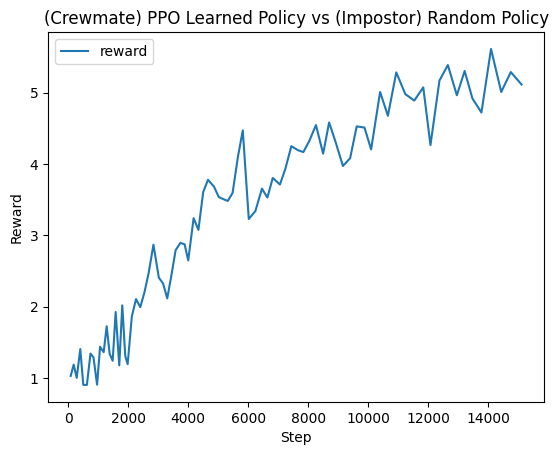

In [181]:
import matplotlib.pyplot as plt

# plot the rewards against random
x, y= zip(*crewmate_rewards_history['random random random'])


plt.plot(x, y, label='reward')
plt.title('(Crewmate) PPO Learned Policy vs (Impostor) Random Policy')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

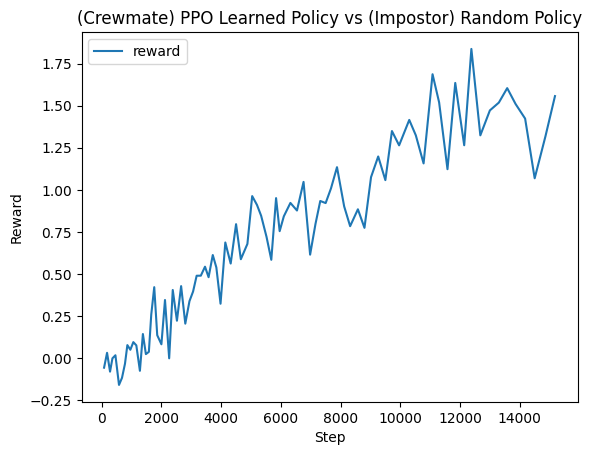

In [182]:
import matplotlib.pyplot as plt

# plot the rewards against random
x, y= zip(*crewmate_rewards_history['greedy greedy greedy'])


plt.plot(x, y, label='reward')
plt.title('(Crewmate) PPO Learned Policy vs (Impostor) Random Policy')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot the rewards against random
x, y= zip(*crewmate_rewards_history['greedy greedy greedy'])


plt.plot(x, y, label='reward')
plt.title('(Crewmate) PPO Learned Policy vs (Impostor) Random Policy')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()